In [159]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

**Plate description**:\
Plate number 705\
Strain: C2\
Crossdate: 10/14\
Prince position: 21\
PRINCE FULL DATA: 20221116_0311_Plate21

**General presentation**\
Groundtruth close-up images were taken at high magnification for a total of 64 close up images.\
The close up images were taken with a tilted plate to have a more precise focus choice.\
I labeled the groundtruth images with _labelme_, setting labels with names by its position.
I also labeled the same exact location on prince image for each groundtruth, by using the coordinate transformation from joystick referential to Prince referential, identifying the tile and setting a label also with _labelme_.
The Prince labels were set on the image that was found to be the more focused.

**This notebook**\
This notebook is for dataset generation

In [160]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("/Users/kai/Downloads/graduation/AMFtrack")
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import json
import imageio
import logging
import cv2
from skimage.measure import profile_line

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_full,
    reconstruct_image_from_general,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
    plot_full,
)

from amftrack.util.sys import get_current_folders, update_plate_info, test_path
from amftrack.util.plot import show_image
from amftrack.util.sys import storage_path
from amftrack.util.geometry import (
    generate_index_along_sequence,
    centered_bounding_box,
    expand_segment,
    get_section_segment,
    compute_factor,
    generate_index_along_sequence,
    distance_point_pixel_line,
    get_closest_lines,
    get_closest_line_opt,
    intersect_rectangle,
    is_overlapping,
    get_overlap,
    format_region,
    is_in_bounding_box,
    get_bounding_box,
    centered_bounding_box,
)
from amftrack.util.image_analysis import (
    find_transformation,
    get_transformation,
    reverse_transformation,
    convert_to_micrometer,
    find_image_index,
    is_in_image,
    extract_inscribed_rotated_image,
    is_negative_similarity,
    find_similarity,
    find_scaling_factor,
)
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    compute_edge_width_profile,
    extract_section_profiles_for_edge,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
def get_labelme_segments(directory):
    # https://github.com/wkentaro/labelme
    labelme_dict = {}
    def load_labelmefile(file):
        with open(file) as r:
            return json.load(r)
    for labelmefiles in os.listdir(directory):
        if ".json" in labelmefiles:
            labelme_path = os.path.join(directory,labelmefiles)
            labelmefile = load_labelmefile(labelme_path)
            for shape in labelmefile["shapes"]:
                if shape["label"] in labelme_dict.keys():
                    labelme_dict[shape["label"]].append(shape["points"])
                else:
                    labelme_dict[shape["label"]]= [shape["points"]]
    return labelme_dict
segment = get_labelme_segments("/Users/kai/Downloads/graduation/Experiment/Labelme/Plate705_20221116")

In [162]:
import numpy as np
def compute_width_from_segment(segment):
    def convert_to_micrometer(pixel_length,camera_res=3.45, magnification=50):
        """
        Converts pixels into micrometers, based on the magnification of the microscope.
        """
        return pixel_length * camera_res / magnification
    width_dict = {}
    width_std_dict = {}
    for key in segment.keys():
        widths = []
        for point1,point2 in segment[key]:
            point1 = np.array(point1)
            point2 = np.array(point2)
            width = convert_to_micrometer(np.linalg.norm(point1 - point2), magnification=50)
            widths.append(width)
        width_dict[key] = np.mean(widths)
        width_std_dict[key] = np.std(widths)
    return width_dict, width_std_dict
width_dict,width_std_dict= compute_width_from_segment(segment)

In [5]:
print("The total positions I took are 64, and each position I extract at least 2 edges.\n\
To minimize the bias I compute at least 3 segment." + f"Final number of groundtruth: {len(width_dict)}")

The total positions I took are 64, and each position I extract at least 2 edges.
To minimize the bias I compute at least 3 segment.Final number of groundtruth: 260


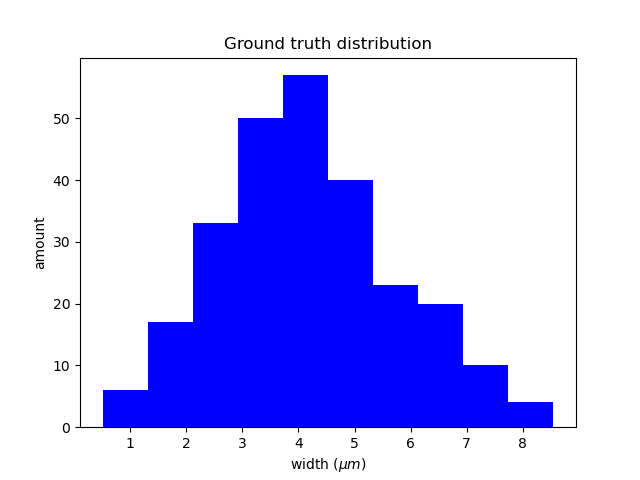

In [163]:
%matplotlib widget
width = list(width_dict.values())
plt.hist(width,color="blue")
plt.title("Ground truth distribution")
plt.xlabel("width ($\mathit{\mu m}$)")
plt.ylabel("amount")
plt.show()

In [164]:
df = pd.DataFrame(list(width_dict.items()),columns=["pos","width"]).set_index("pos")
df = df.sort_index()
df.to_excel("output.xlsx")

In [165]:
directory_groundtruths = os.path.join(storage_path)
directory_groundtruths

'/Users/kai/Downloads/graduation/code/datasets'

In [166]:
directory = directory_groundtruths +"/"
directory

'/Users/kai/Downloads/graduation/code/datasets/'

In [167]:
update_plate_info(directory)

analysed:   0%|          | 0/44 [00:00<?, ?it/s]

In [169]:
folder_df = get_current_folders(directory)
folder_df

total_path Plate PrincePos  \
0  /Users/kai/Downloads/graduation/code/datasets/...   705        21   
1  /Users/kai/Downloads/graduation/code/datasets/...  1045         2   
2  /Users/kai/Downloads/graduation/code/datasets/...   452        32   

       root strain          medium split Pbait CrossDate Temperature  ...  \
0  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221014          25  ...   
1  'Carrot'   'C2'  '001P100N200C'   'Y'   '-'  20220504          25  ...   
2  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221017          25  ...   

  /Analysis/transform.mat /Analysis/transform_corrupt.mat  \
0                    True                           False   
1                    True                           False   
2                    True                           False   

  /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
0                                        True                        True   
1                                        True                        True   
2                                        True                        True   

  /Analysis/nx_graph_pruned_width.p /Analysis/nx_graph_pruned_labeled.p  \
0                              True                                True   
1                              True                                True   
2                              True                                True   

                 date                 folder      unique_id  \
0  16.11.2022, 03:11:  20221116_0311_Plate21   705_20221014   
1  08.05.2022, 09:47:  20220508_0947_Plate02  1045_20220504   
2  26.10.2022, 10:13:  20221026_1013_Plate32   452_20221017   

             datetime  
0 2022-11-16 03:11:00  
1 2022-05-08 09:47:00  
2 2022-10-26 10:13:00  

[3 rows x 24 columns]

In [170]:
select = folder_df[folder_df["Plate"] == "705"]
select

total_path Plate PrincePos  \
0  /Users/kai/Downloads/graduation/code/datasets/...   705        21   

       root strain          medium split Pbait CrossDate Temperature  ...  \
0  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221014          25  ...   

  /Analysis/transform.mat /Analysis/transform_corrupt.mat  \
0                    True                           False   

  /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
0                                        True                        True   

  /Analysis/nx_graph_pruned_width.p /Analysis/nx_graph_pruned_labeled.p  \
0                              True                                True   

                 date                 folder     unique_id            datetime  
0  16.11.2022, 03:11:  20221116_0311_Plate21  705_20221014 2022-11-16 03:11:00  

[1 rows x 24 columns]

2022-11-16 03:11:00


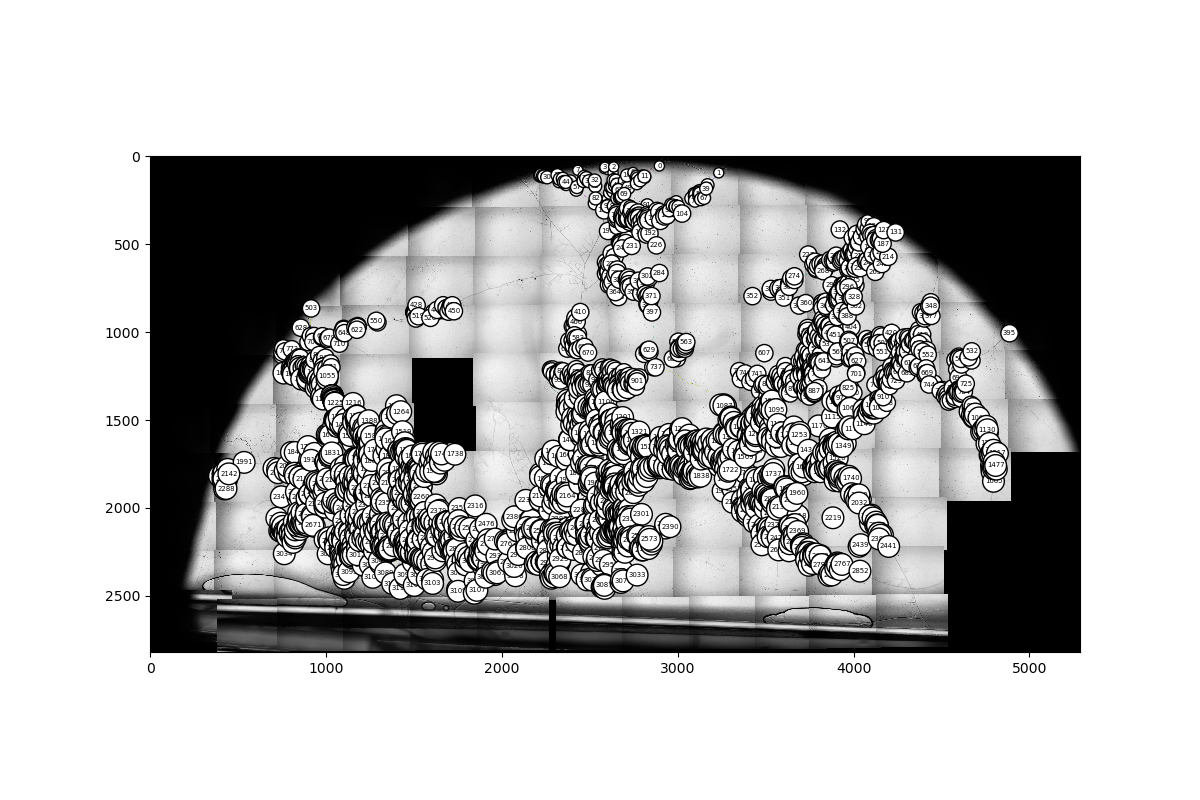

In [20]:
%matplotlib widget
exp = Experiment(directory)
exp.load(select, suffix="")
exp.load_tile_information(0)
plot_full_image_with_features(exp, 0, 
                              downsizing=10,
                              dilation=1,
                              edges=get_all_edges(exp, 0),
                              nodes=get_all_nodes(exp, 0))

you select number 21 tile


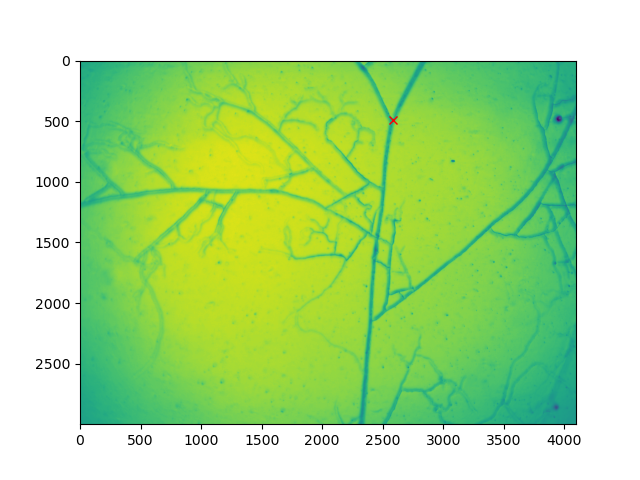

In [21]:
%matplotlib widget
def select_tile(row,column):
    row_count=-1
    row_list = [6,9,11,13,12,13,13,12,12]
    for i in range(row):
        row_count+=1
    if row_count == 0:
        print(f"you select number {column} tile")
        return column-1
    else:
        number = column + sum(row_list[:row_count])
    print(f"you select number {number+1} tile")
    return number
tile = select_tile(3,5)
# image_paths[t][tile_number]
# select_pic = [] 
show_image(exp.image_paths[0][tile])
plt.plot(2581, 489, marker="x", color="red")


In [171]:
import pandas as pd
select_exp = "/Users/kai/Downloads/graduation/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="11.16",skiprows=1,index_col=0,header=0)
exp_df

x      y   x_e   y_e file name Unnamed: 6 Unnamed: 7  \
Name                                                              
pos1   27780  19520  2473   610   focus01    focus02    focus03   
pos2   27460  22060  2455   776     pos02        NaN        NaN   
pos3   27480  23580  2444   878     pos03        NaN        NaN   
pos4   27140  26220  2428  1046     pos04        NaN        NaN   
pos5   27220  26960  2430  1046     pos05        NaN        NaN   
...      ...    ...   ...   ...       ...        ...        ...   
pos60   3960  26000   913  1028     pos60        NaN        NaN   
pos61   9720  24780  1290   941     pos61        NaN        NaN   
pos62  11460  24600  1400   932     pos62        NaN        NaN   
pos63  27540  35940  2438  1689     pos63        NaN        NaN   
pos64  28000  35740  2468  1679     pos64        NaN        NaN   

         Crossed date  2022-10-14 00:00:00  
Name                                        
pos1           Strain                   C2  
pos2             Root               carrot  
pos3   plate position                   21  
pos4         Exp date  2022-11-16 00:00:00  
pos5              NaN                  NaN  
...               ...                  ...  
pos60             NaN                  NaN  
pos61             NaN                  NaN  
pos62             NaN                  NaN  
pos63             NaN                  NaN  
pos64             NaN                  NaN  

[64 rows x 9 columns]

In [172]:
x_data = [i for i in exp_df.x]
y_data = [i for i in exp_df.y]
possdm1 = []
for i in range(len(x_data)):
    possdm1.append([x_data[i],y_data[i]])

In [173]:
x_data = [10*i for i in exp_df.x_e]
y_data = [10*i for i in exp_df.y_e]
possdm2 = []
for i in range(len(x_data)):
    possdm2.append([y_data[i],x_data[i]])
#Notice the x and y position should reverse.

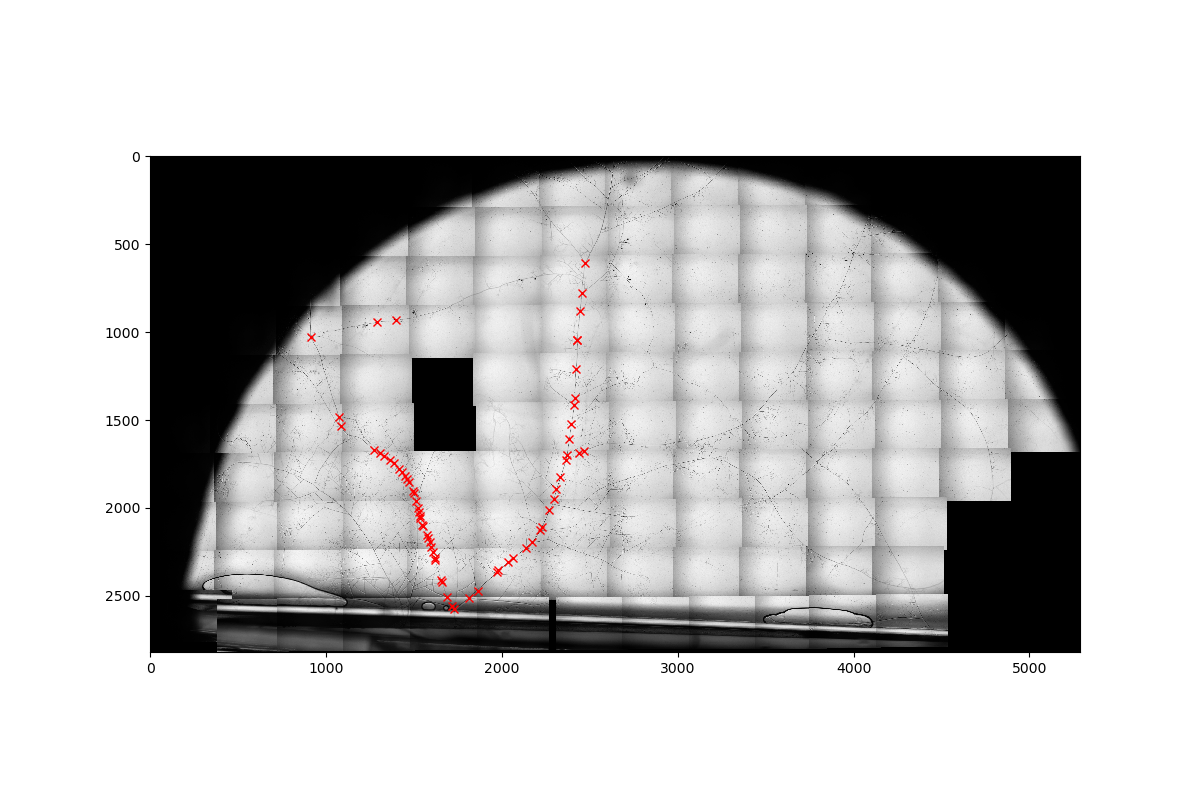

In [174]:
%matplotlib widget
plot_full_image_with_features(
    exp,
    t=0,
    downsizing=10,
    # region=[[0, 0], [26000, 52000]],
    points=possdm2,
)


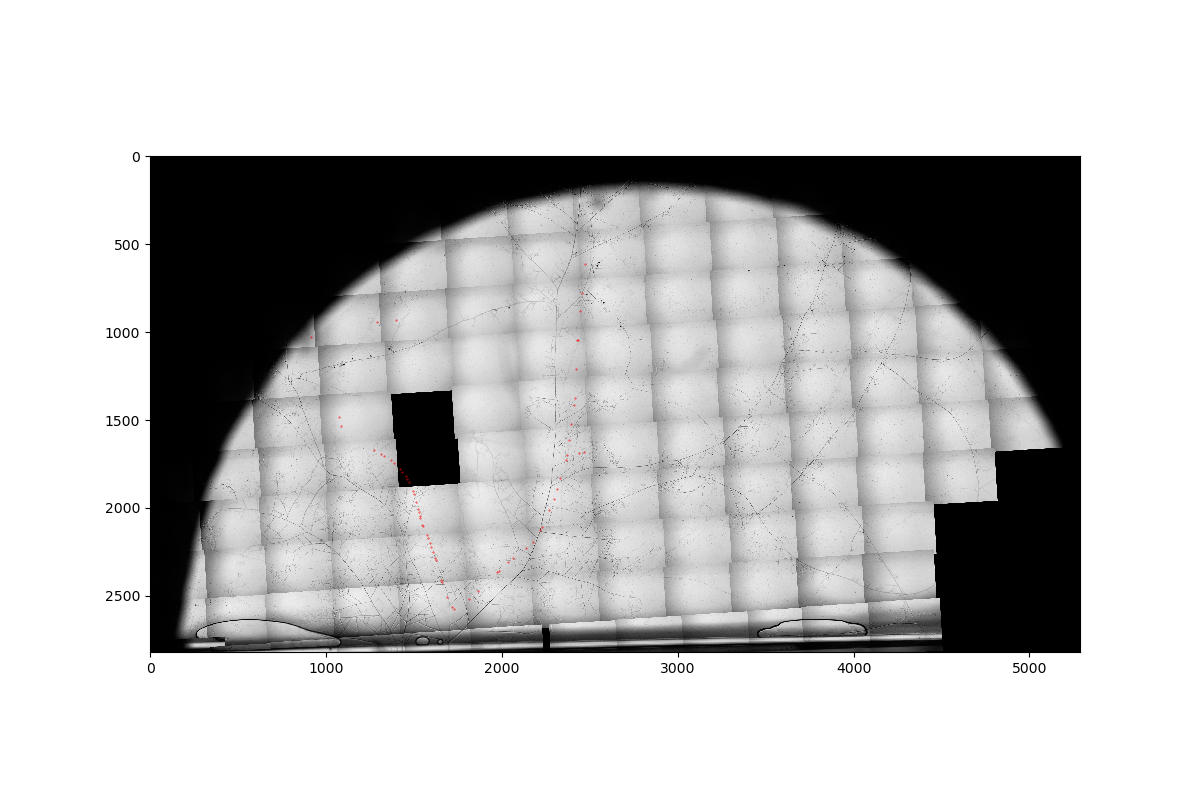

In [175]:
# Need to fix
%matplotlib widget
plot_full(
    exp,
    t=0,
    downsizing=10,
    # region=[[0, 0], [26000, 52000]],
    points=possdm2,
)

In [177]:
import pandas as pd
select_exp = "/Users/kai/Downloads/graduation/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df_node= pd.read_excel(select_exp,engine = "openpyxl",sheet_name="experiment node",index_col=0)
exp_df_node

position        top           R  R2           D   D2  D3         M  \
pos3      410.0        NaN         NaN NaN    410, 556  NaN NaN       NaN   
pos4      598.0   583, 598         NaN NaN    601, 662  NaN NaN  598, 601   
pos5      662.0   601, 662    664, 657 NaN    664, 793  NaN NaN  662, 664   
pos6      814.0   664, 793    793, 827 NaN    793, 814  NaN NaN       NaN   
pos7     1099.0  1099, 983  1099, 1079 NaN  1099, 1142  NaN NaN       NaN   
...         ...        ...         ...  ..         ...  ...  ..       ...   
pos60     681.0   673, 503    673, 671 NaN    681, 708  NaN NaN  681, 673   
pos61       NaN        NaN    559, 521 NaN         NaN  NaN NaN       NaN   
pos62       NaN        NaN    559, 521 NaN         NaN  NaN NaN       NaN   
pos63    1641.0        NaN  1641, 1611 NaN  1641, 1689  NaN NaN       NaN   
pos64    1611.0        NaN  1611, 1567 NaN  1611, 1664  NaN NaN       NaN   

             M2   M3  ...   L3   L4   L5        LT   RT   LM  LM2   LD  \
pos3        NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos4   598, 601  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos5   662, 664  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos6        NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos7        NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
...         ...  ...  ...  ...  ...  ...       ...  ...  ...  ...  ...   
pos60  681, 673  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos61       NaN  NaN  ...  NaN  NaN  NaN  559, 550  NaN  NaN  NaN  NaN   
pos62       NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos63       NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   
pos64       NaN  NaN  ...  NaN  NaN  NaN       NaN  NaN  NaN  NaN  NaN   

             MT        MD  
pos3        NaN       NaN  
pos4        NaN       NaN  
pos5        NaN       NaN  
pos6        NaN       NaN  
pos7        NaN       NaN  
...         ...       ...  
pos60       NaN       NaN  
pos61  559, 550  559, 550  
pos62       NaN       NaN  
pos63       NaN       NaN  
pos64       NaN       NaN  

[62 rows x 22 columns]

In [178]:
label_pos = list(exp_df_node.columns[1:])
pos_dict = {}
for i in range(len(exp_df_node)):
    pic_pos = exp_df_node.index[i]
    node_dict = {}
    for index, value in enumerate(exp_df_node.iloc[i,1:]):
        if type(value) == str:
            node1, node2 = value.split(",")
            node_dict[label_pos[index]] = [int(node1),int(node2)]
    if len(node_dict) != 0:
        pos_dict[pic_pos] = node_dict

In [179]:
check = 0
for i in pos_dict.keys():
    check += len(pos_dict[i].values())
print(f"Total of the edge I am going to measure is {check} edges.")

Total of the edge I am going to measure is 195 edges.


In [180]:
# check the segment to prevent extract the wrong segment
pos = "pos64"
direction = "L"
pos_dict[pos]

{'R': [1611, 1567], 'D': [1611, 1664], 'L': [1611, 1641]}

In [181]:
edges = []
for edge in [pos_dict[pos][direction]]:
    edges.append(get_edge_from_node_labels(exp, 0, edge[0], edge[1]))
edges
start_nodes = [edge.begin for edge in edges]
end_nodes = [edge.end for edge in edges]
nodes = [node for l in [start_nodes, end_nodes] for node in l ]
nodes

[Node(1641), Node(1611)]

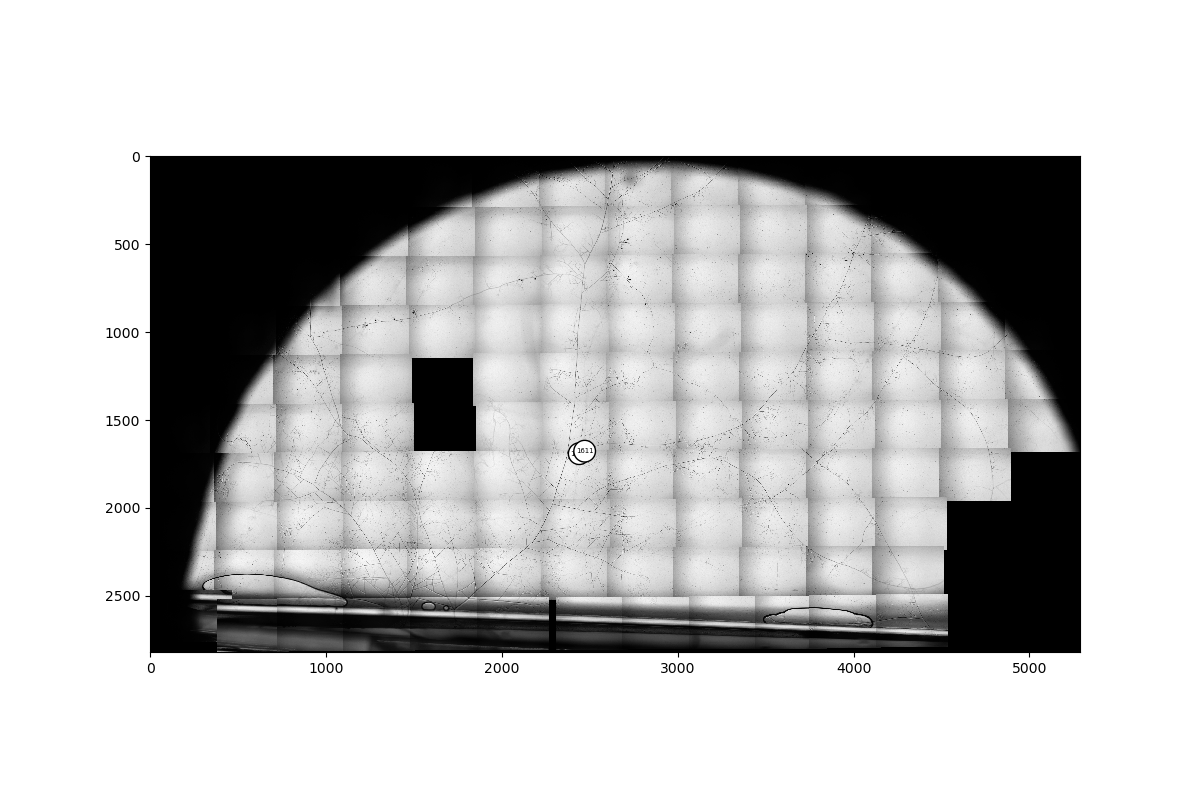

In [182]:
%matplotlib widget
plot_full_image_with_features(
    exp, 0, downsizing=10, dilation=1, edges=edges, nodes=nodes)

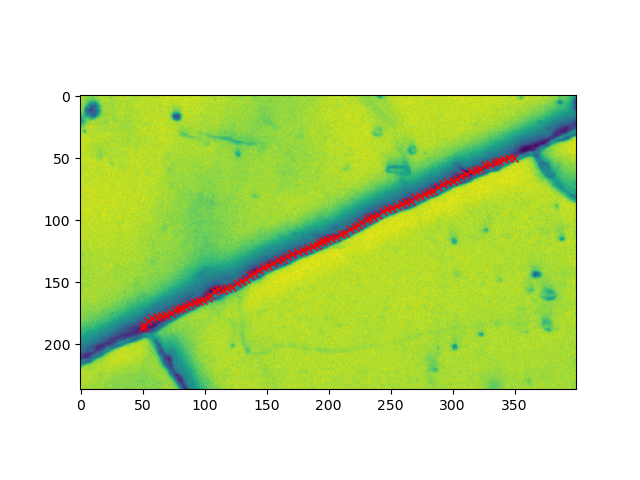

In [183]:
%matplotlib widget
edge = pos_dict[pos][direction]
edge = get_edge_from_node_labels(exp, 0, edge[0], edge[1])
f = lambda n: generate_index_along_sequence(n, resolution=4, offset=5)
f_profiles = lambda edge: extract_section_profiles_for_edge(
    exp, 0, edge, resolution=5, offset=5, step=1)
plot_edge_cropped(edge, 0, mode=3, f=f)

68


3

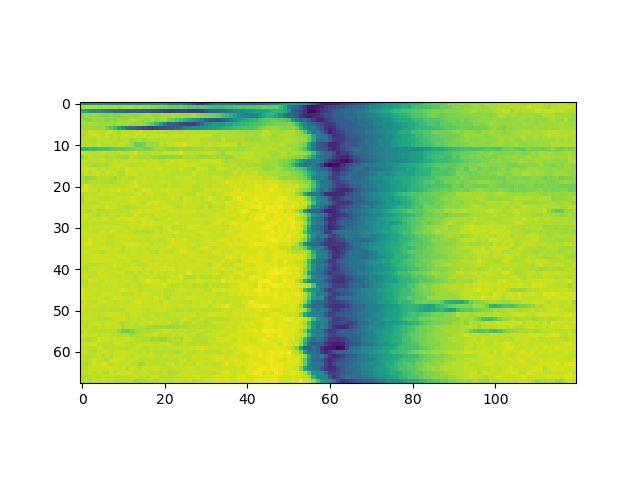

In [184]:
%matplotlib widget
slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices)
print(len(slices))
len(slices[0:3])

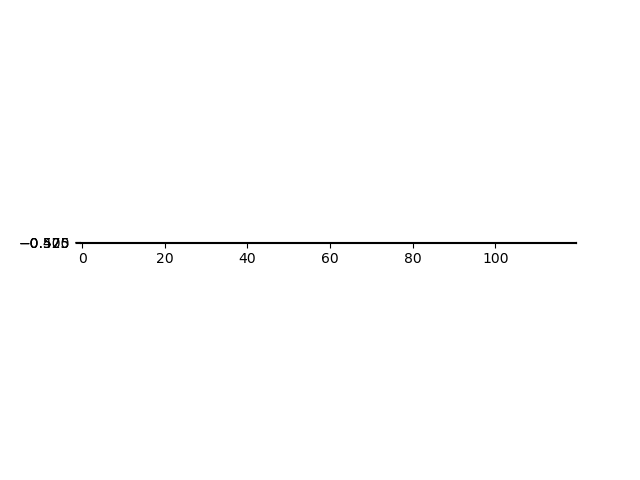

In [35]:
%matplotlib widget
# slices, coords1, coords2 = f_profiles(edge)
plt.imshow(slices[308:311])

In [36]:
# ask the difference between plot_full and plot_full_image_with_features => plot_full_image_with already rotate
# ask camera_res keep 3.45 => the value gave from the company
# ask how to distinguish the different hyphae => define by yourself
# check the authothority with ICT => To get the 

In [71]:
import pandas as pd
select_exp = "/Users/kai/Downloads/graduation/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df_slice = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="experiment slice",index_col=0)
exp_df_slice

position        top          R  R2          D   D2  D3      M      M2  \
pos3      410.0        NaN        NaN NaN    [10:12]  NaN NaN    NaN     NaN   
pos4      598.0    [23:25]        NaN NaN    [12:14]  NaN NaN  [1:3]   [3:5]   
pos5      662.0    [92:95]      [3:6] NaN  [213:217]  NaN NaN  [1:2]   [2:3]   
pos6      814.0      [1:4]      [4:6] NaN    [15:17]  NaN NaN    NaN     NaN   
pos7     1099.0  [170:173]      [3:5] NaN    [80:83]  NaN NaN    NaN     NaN   
...         ...        ...        ...  ..        ...  ...  ..    ...     ...   
pos60     681.0  [308:311]      [1:4] NaN      [1:4]  NaN NaN  [0:3]  [7:10]   
pos61       NaN        NaN      [0:3] NaN        NaN  NaN NaN    NaN     NaN   
pos62       NaN        NaN  [178:180] NaN        NaN  NaN NaN    NaN     NaN   
pos63    1641.0        NaN      [1:4] NaN      [1:4]  NaN NaN    NaN     NaN   
pos64    1611.0        NaN      [1:4] NaN      [1:4]  NaN NaN    NaN     NaN   

        M3  ...   L3   L4   L5      LT   RT   LM  LM2   LD     MT     MD  
pos3   NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos4   NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos5   NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos6   NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos7   NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
...    ...  ...  ...  ...  ...     ...  ...  ...  ...  ...    ...    ...  
pos60  NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos61  NaN  ...  NaN  NaN  NaN  [9:12]  NaN  NaN  NaN  NaN  [4:6]  [2:4]  
pos62  NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos63  NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  
pos64  NaN  ...  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN    NaN    NaN  

[62 rows x 22 columns]

In [43]:
labelme_df = pd.DataFrame.from_dict(width_dict,orient='index')
labelme_df = labelme_df.sort_index()
labelme_df.to_excel("labelme_raw.xlsx")

In [44]:
for index, value in labelme_df.iterrows():
    if len(index.split("_")) == 2:
        pos, direction = index.split("_")
        exp_df.at[pos.lower(),direction]=value[0]

In [72]:
select_exp = "/Users/kai/Downloads/graduation/Experiment/Labelme/Fluorescence_ex_Kai-kai_Plate705.xlsx"
label_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="Labelme",index_col=0)
label_df

position       top         R  R2         D  D2  D3         M        M2  \
pos3      410.0  5.466252  3.360181 NaN  5.978320 NaN NaN       NaN       NaN   
pos4      598.0  3.890178       NaN NaN  4.738162 NaN NaN  4.940548  4.970713   
pos5      662.0  3.867490  2.815162 NaN  4.811456 NaN NaN  4.886012  4.084507   
pos6      814.0  5.118606  3.163404 NaN  4.191390 NaN NaN       NaN       NaN   
pos7     1099.0  4.057369  3.093466 NaN  5.192105 NaN NaN       NaN       NaN   
...         ...       ...       ...  ..       ...  ..  ..       ...       ...   
pos60     681.0  8.546125  7.723462 NaN  6.794172 NaN NaN  8.260645  7.327132   
pos61       NaN       NaN  3.494587 NaN       NaN NaN NaN       NaN       NaN   
pos62       NaN  3.247844  4.441835 NaN       NaN NaN NaN       NaN       NaN   
pos63    1641.0       NaN  4.753152 NaN  4.250022 NaN NaN       NaN       NaN   
pos64    1611.0       NaN  4.773153 NaN  4.225286 NaN NaN       NaN       NaN   

       M3  ...  L3  L4  L5        LT  RT  LM  LM2  LD        MT        MD  
pos3  NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos4  NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos5  NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos6  NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos7  NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
...    ..  ...  ..  ..  ..       ...  ..  ..  ...  ..       ...       ...  
pos60 NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos61 NaN  ... NaN NaN NaN  2.635567 NaN NaN  NaN NaN  2.809692  2.938713  
pos62 NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos63 NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  
pos64 NaN  ... NaN NaN NaN       NaN NaN NaN  NaN NaN       NaN       NaN  

[62 rows x 22 columns]

In [75]:
# get the dict for slice
label_pos = list(exp_df_slice.columns[1:])
slices_dict = {}
for i in range(len(exp_df_slice)):
    pic_pos = exp_df_slice.index[i]
    slice_dict = {}
    for index, value in enumerate(exp_df_slice.iloc[i,1:]):
        if type(value) == str:
            first, second= value.replace("[","").replace("]","").split(":")
            slice_dict[label_pos[index]] = [int(first), int(second)]
    if len(slice_dict) != 0:
        slices_dict[pic_pos] = slice_dict

In [76]:
# get the dict for label
import math 
label_pos = list(label_df.columns[1:])
labels_dict = {}
for i in range(len(label_df)):
    pic_pos = label_df.index[i]
    label_dict = {}
    for index, value in enumerate(label_df.iloc[i,1:]):
        if not math.isnan(value):
            label_dict[label_pos[index]] = value
    if len(label_dict) != 0:
        labels_dict[pic_pos] = label_dict

In [77]:
# get the dict for node
label_pos = list(exp_df_node.columns[1:])
nodes_dict = {}
for i in range(len(exp_df_node)):
    pic_pos = exp_df_node.index[i]
    node_dict = {}
    for index, value in enumerate(exp_df_node.iloc[i,1:]):
        if type(value) == str:
            node1, node2 = value.split(",")
            node_dict[label_pos[index]] = [int(node1),int(node2)]
    if len(node_dict) != 0:
        nodes_dict[pic_pos] = node_dict

In [125]:
# create a dataset
f_profiles = lambda edge: extract_section_profiles_for_edge(exp, 0, edge, resolution=5, offset=5, step=1)
target_length = 120
collect_slice = []
collect_labels = []
for slice_key in slices_dict.keys():
    for slice_pos in slices_dict[slice_key].keys():
        edge = nodes_dict[slice_key][slice_pos]
        edge = get_edge_from_node_labels(exp, 0, edge[0], edge[1])
        slices, coords1, coords2 = f_profiles(edge)
        start, end  = slices_dict[slice_key][slice_pos]
        collect_slice.extend(slices[start:end])
        collect_labels.extend([labels_dict[slice_key][slice_pos]]*len(slices[start:end]))

In [156]:
slice_array = np.array(collect_slice)
label_array = np.array(collect_labels)
print(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")

Slice array: (542, 120) Label array: (542,)


In [158]:
os.mkdir(os.path.join(storage_path, "vary_width"))
cv2.imwrite(os.path.join(storage_path, "vary_width","slices.png"), slice_array)
with open(os.path.join(storage_path, "vary_width","labels.npy"), "wb") as f:
    np.save(f, label_array)
with open(os.path.join(storage_path, "vary_width","info.txt"), "w") as f:
    f.write(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")
    f.write('\nPlate number 705\nStrain: C2\nCrossdate: 10/14\nPrince position: 21\nPRINCE FULL DATA: 20221116_0311_Plate21')